### Imports

In [6]:
import pandas as pd
import numpy as np

from pyhhmm.gaussian import GaussianHMM
from pandas_datareader.data import DataReader

import yfinance as yf
yf.pdr_override()

import matplotlib.pyplot as plt

In [7]:
# Data Extraction

start_date = '2017-01-01'
end_date = '2024-01-14'
symbol = 'BTC-USD'
data = DataReader(symbol, start_date, end_date) 

[*********************100%%**********************]  1 of 1 completed


In [8]:
# Manage Data and Add Features

data.drop(columns=['Close'], inplace=True)
df = data.copy()
df['returns'] = df['Adj Close']/df['Adj Close'].shift(1) - 1  
df['range'] = df['High']/df['Low'] -1

df.dropna(inplace=True)

df.head()

,Open,High,Low,Adj Close,Volume,returns,range
Date,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,-0.122410,0.308302
2017-01-06,1014.239990,1046.810059,883.943970,902.200989,351876000,-0.109711,0.184249


In [9]:
# Structure Data for HMM

X_train = df[['returns', 'range']]
X_train.head()


,returns,range
Date,,
2017-01-02,0.023464,0.034803
2017-01-03,0.021620,0.022005
2017-01-04,0.106233,0.110130
2017-01-05,-0.122410,0.308302
2017-01-06,-0.109711,0.184249


### HMM Learning

In [10]:
# Fit HMM

model = GaussianHMM(n_states=3, covariance_type="full", n_emissions=2)
model.train([np.array(X_train.values)])

(<pyhhmm.gaussian.GaussianHMM at 0x2bd1e121c70>, 11065.286895746569)

In [11]:
# Check Results

hidden_states = model.predict([X_train.values])[0]
hidden_states[:30]

array([0, 0, 2, 1, 1, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2])

In [12]:
# Regime state means for each feature
model.means

array([[-0.00054413,  0.02777579],
       [-0.04040166,  0.08551856],
       [ 0.03405127,  0.06016252]])

In [13]:
# Regime state covars for each feature
model.covars

array([[[ 1.88975338e-04, -1.32623416e-05],
        [-1.32623416e-05,  1.63970882e-04]],

       [[ 1.44331269e-03, -1.53336420e-03],
        [-1.53336420e-03,  3.46815542e-03]],

       [[ 1.29348594e-03,  1.19853759e-03],
        [ 1.19853759e-03,  1.69613640e-03]]])

### Data Visualization

In [14]:
# Structure Prices for plotting

prices = df['Adj Close'].values.astype(float)
print('Correct number of rows ', len(prices)==len(hidden_states))

i=0
labels_0 = []
labels_1 = []
labels_2 = []


for state in hidden_states:
    if state == 0:
        labels_0.append(prices[i])
        labels_1.append(np.nan)
        labels_2.append(np.nan)
        
    elif state == 1:
        labels_0.append(np.nan)
        labels_1.append(prices[i])
        labels_2.append(np.nan)
        
    else:
        labels_0.append(np.nan)
        labels_1.append(np.nan)
        labels_2.append(prices[i])
        

    i+=1



Correct number of rows  True


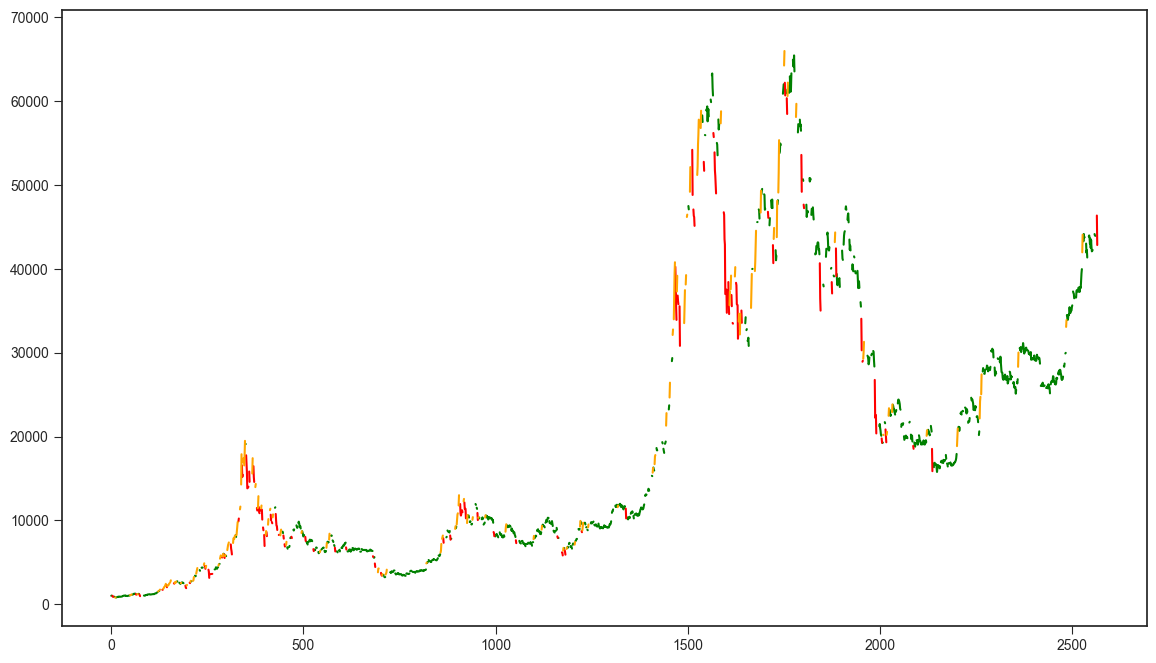

In [18]:
# Plot Results

fig = plt.figure(figsize=(14,8))
plt.plot(labels_0, color='green')
plt.plot(labels_1, color='red')
plt.plot(labels_2, color='orange')

plt.show()